# DATA READING & LABELING

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Flatten, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

In [3]:
%pip install gdown
import gdown

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/54/70/e07c381e6488a77094f04c85c9caf1c8008cdc30778f7019bc52e5285ef0/gdown-5.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/41/24/0b023b6537dfc9bae2c779353998e3e99ac7dfff4222fc6126650e93c3f3/filelock-3.14.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
file_1 = '1OO4z7HY5NaxQCgrJjt84L7AizK2V3xXj'  # Replace with your file ID
file_2 = '1DpinanlwP0hIXtRnegYBek5sp5siqCQU'
url_1 = f'https://drive.google.com/uc?id={file_1}'
url_2 = f'https://drive.google.com/uc?id={file_2}'
output_1 = './dataset_mentah.csv'  # Replace with the desired file name
output_2 = './kbbi.csv'
gdown.download(url_1, output_1, quiet=False)
gdown.download(url_2, output_2, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1OO4z7HY5NaxQCgrJjt84L7AizK2V3xXj
From (redirected): https://drive.google.com/uc?id=1OO4z7HY5NaxQCgrJjt84L7AizK2V3xXj&confirm=t&uuid=a7451612-a53d-4136-bb07-10b12a79e2d7
To: d:\PerjokianDuniawi\Klasifikasi Berita LSTM\Klasifikasi Berita LSTM_2\dataset_mentah.csv
 31%|███       | 76.0M/247M [00:13<00:26, 6.45MB/s]

KeyboardInterrupt: 

 31%|███       | 76.0M/247M [00:30<00:26, 6.45MB/s]

In [102]:
berita_raw = pd.read_csv('dataset_mentah.csv',sep=';')
kbbi_corp = pd.read_csv('kbbi.csv')
kata_formal_kbbi = set(kbbi_corp['kbbi'].str.lower())

In [103]:
berita = berita_raw[:50000]

In [7]:
kbbi_corp

,kbbi
0,kata
1,angkak
2,askriptif
3,amfiprotik
4,apologia
...,...
70879,zakiah
70880,zenital
70881,zulhijah
70882,zeolit


In [108]:
berita.describe()

,content,tags,title
count,50000,49998,50000
unique,50000,46829,49993
top,", - Kapten Supardi Nasir berharap Kompetisi ...",COVID-19,\r\n\t\t\t\t\t\t\tBMKG Beri Peringatan Dini Cu...
freq,1,33,2


In [106]:
# set treshold for labeling the dataset
def clean_up(berita):
  threshold = 0.9

  # data cleaning
  berita['content'] = berita['content'].str.lower()
  berita['content'] = berita['content'].apply(lambda kalimat: re.sub(r'[^a-zA-Z\s]', '', kalimat))
  berita['content'] = berita['content'].apply(lambda kalimat: re.sub(r'[\r\n\t]', ' ', kalimat))
  berita['content'] = berita['content'].apply(lambda kalimat: re.sub(r'\s+', ' ', kalimat))

  # handling NaN data
  berita['content'] = berita['content'].fillna('')  # Menggantikan nilai NaN dengan string kosong

  # clean and add the label based on threshold
  berita['label'] = berita['content'].apply(lambda kalimat: 'formal' if sum(1 for kata in kalimat.split() if kata.lower() in kata_formal_kbbi) >= len(kalimat.split()) * threshold else 'non formal')

  return berita

In [110]:
berita = clean_up(berita)

<ipython-input-106-0a673b8bb530>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berita['content'] = berita['content'].str.lower()
<ipython-input-106-0a673b8bb530>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berita['content'] = berita['content'].apply(lambda kalimat: re.sub(r'[^a-zA-Z\s]', '', kalimat))
<ipython-input-106-0a673b8bb530>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

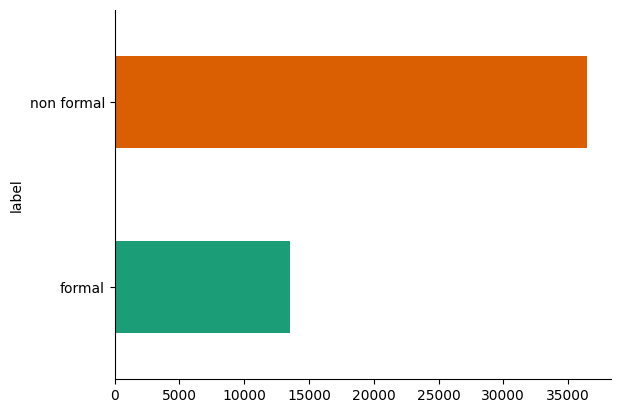

In [10]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
berita.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
label = np.array([ 0 if word == 'formal' else 1 for word in berita['label']])

# TEXT CLASSIFICATION

PREPROCESSING Word2Vec

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stop words
    stop_words = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Example usage
sample_text = "Hello world! This is a sample text for preprocessing."
cleaned_tokens = preprocess_text(sample_text)
print(cleaned_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


['hello', 'world', 'this', 'is', 'a', 'sample', 'text', 'for', 'preprocessing']


In [13]:
content = berita['content']

In [14]:
proceed_content = content.apply(preprocess_text)

In [15]:
len(proceed_content[300])

132

In [16]:
from gensim.models import Word2Vec

wordvector = Word2Vec(sentences=proceed_content, vector_size=100, window=10, min_count=0, workers=4)

In [18]:
len(wordvector.wv)

334991

In [17]:
similar_words = wordvector.wv.most_similar('hidup', topn=10)
print(similar_words)

[('kehidupan', 0.6275185346603394), ('hajat', 0.6059792041778564), ('godalming', 0.6025648713111877), ('hidupnya', 0.5938637852668762), ('patungsemangat', 0.5835499167442322), ('seumur', 0.5833452939987183), ('tersedaknya', 0.580808162689209), ('cukasetelah', 0.5746611952781677), ('kelangsungan', 0.5746349692344666), ('berdamai', 0.5710709095001221)]


Preprocessing Tokenizer

In [19]:
tok = Tokenizer(num_words=50000)
tok.fit_on_texts(proceed_content)

In [20]:
len(tok.word_index)

334991

In [21]:
seq = tok.texts_to_sequences(proceed_content)
max_length = 100
X_pad = pad_sequences(seq, maxlen=max_length)

In [22]:
X_train_pad, X_pad, y_train_pad, y_pad = train_test_split(X_pad, label, test_size=0.4, random_state=32)
X_val_pad, X_test_pad, y_val_pad, y_test_pad = train_test_split(X_pad, y_pad, test_size=0.5, random_state=32)

# Random function

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lstm_gate_activations(model, layer_name, X_train_pad):
    lstm_layer = model.get_layer(name=layer_name)
    weights = lstm_layer.get_weights()

    W = weights[0]  # kernel
    U = weights[1]  # recurrent_kernel
    b = weights[2]  # bias

    units = lstm_layer.units

    W_i = W[:, :units]       # input gate weights
    W_f = W[:, units:units*2] # forget gate weights
    W_c = W[:, units*2:units*3] # cell state weights
    W_o = W[:, units*3:]     # output gate weights

    U_i = U[:, :units]       # input gate recurrent weights
    U_f = U[:, units:units*2] # forget gate recurrent weights
    U_c = U[:, units*2:units*3] # cell state recurrent weights
    U_o = U[:, units*3:]     # output gate recurrent weights

    b_i = b[:units]          # input gate bias
    b_f = b[units:units*2]   # forget gate bias
    b_c = b[units*2:units*3] # cell state bias
    b_o = b[units*3:]        # output gate bias

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    C_t_minus_1 = np.zeros(units)
    h_t_minus_1 = np.zeros(units)

    input_gate_activations = []
    forget_gate_activations = []
    output_gate_activations = []
    cell_state_activations = []

    for t in range(X_train_pad.shape[1]):
        x_t = X_train_pad[0, t, :]  # input at time step t

        i_t = sigmoid(np.dot(x_t, W_i) + np.dot(h_t_minus_1, U_i) + b_i)
        f_t = sigmoid(np.dot(x_t, W_f) + np.dot(h_t_minus_1, U_f) + b_f)
        o_t = sigmoid(np.dot(x_t, W_o) + np.dot(h_t_minus_1, U_o) + b_o)
        C_tilde_t = np.tanh(np.dot(x_t, W_c) + np.dot(h_t_minus_1, U_c) + b_c)

        C_t = f_t * C_t_minus_1 + i_t * C_tilde_t
        h_t = o_t * np.tanh(C_t)

        # Print activations
        if t == 1:
          print(f"Time step {t}")
          print(f"Input gate activation: {i_t}")
          print(f"Forget gate activation: {f_t}")
          print(f"Output gate activation: {o_t}")
          print(f"Cell state: {C_t}")

        input_gate_activations.append(i_t)
        forget_gate_activations.append(f_t)
        output_gate_activations.append(o_t)
        cell_state_activations.append(C_t)

        C_t_minus_1 = C_t
        h_t_minus_1 = h_t

    input_gate_activations = np.array(input_gate_activations)
    forget_gate_activations = np.array(forget_gate_activations)
    output_gate_activations = np.array(output_gate_activations)
    cell_state_activations = np.array(cell_state_activations)

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.plot(np.mean(input_gate_activations, axis=0))
    plt.title('Input Gate Activations')
    plt.xlabel('Units')
    plt.ylabel('Activation Value')

    plt.subplot(1, 4, 2)
    plt.plot(np.mean(forget_gate_activations, axis=0))
    plt.title('Forget Gate Activations')
    plt.xlabel('Units')
    plt.ylabel('Activation Value')

    plt.subplot(1, 4, 3)
    plt.plot(np.mean(output_gate_activations, axis=0))
    plt.title('Output Gate Activations')
    plt.xlabel('Units')
    plt.ylabel('Activation Value')

    plt.subplot(1, 4, 4)
    plt.plot(np.mean(cell_state_activations, axis=0))
    plt.title('Cell State Activations')
    plt.xlabel('Units')
    plt.ylabel('Activation Value')

    plt.tight_layout()
    plt.show()


In [25]:
def get_lstm_input_shape(model, lstm_layer_name):
    """
    Retrieves the input shape of an LSTM layer in a Keras model.

    Parameters:
    model (Model): The Keras model.
    lstm_layer_name (str): The name of the LSTM layer.

    Returns:
    tuple: The input shape of the specified LSTM layer.
    """
    # Find the LSTM layer by name
    lstm_layer = model.get_layer(name=lstm_layer_name)

    # Check if the layer is an LSTM layer
    if 'LSTM' not in str(type(lstm_layer)):
        raise ValueError(f"Layer {lstm_layer_name} is not an LSTM layer.")

    # Retrieve and return the input shape
    input_shape = lstm_layer.input_shape
    return input_shape

# BUILDING MODELS #1

In [26]:
class_weight = {0: 3., 1: 1.}

In [72]:
model1 = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=True, name='lstm-1'),
    LSTM(64, return_sequences=True, name='lstm-2'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

In [73]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 64)           640000    
                                                                 
 lstm-1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm-2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 global_average_pooling1d_3  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                      

In [74]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [75]:
print ('Fitting model...')
hist = model1.fit(X_train_pad, y_train_pad, steps_per_epoch=50, batch_size=64, epochs=20, validation_data=(X_val_pad,y_val_pad), verbose=1, class_weight=class_weight)

Fitting model...
Epoch 1/20
50/50 [==============================] - 12s 174ms/step - loss: 0.9890 - accuracy: 0.4775 - val_loss: 0.5533 - val_accuracy: 0.7046
Epoch 2/20
50/50 [==============================] - 5s 104ms/step - loss: 0.8108 - accuracy: 0.7122 - val_loss: 0.4930 - val_accuracy: 0.7536
Epoch 3/20
50/50 [==============================] - 5s 103ms/step - loss: 0.7554 - accuracy: 0.7437 - val_loss: 0.5177 - val_accuracy: 0.7422
Epoch 4/20
50/50 [==============================] - 5s 107ms/step - loss: 0.7295 - accuracy: 0.7484 - val_loss: 0.4582 - val_accuracy: 0.7771
Epoch 5/20
50/50 [==============================] - 4s 75ms/step - loss: 0.7276 - accuracy: 0.7531 - val_loss: 0.5007 - val_accuracy: 0.7504
Epoch 6/20
50/50 [==============================] - 3s 52ms/step - loss: 0.6725 - accuracy: 0.7825 - val_loss: 0.4757 - val_accuracy: 0.7755
Epoch 7/20
50/50 [==============================] - 5s 101ms/step - loss: 0.6722 - accuracy: 0.7788 - val_loss: 0.4625 - val_accurac

In [76]:
model1.evaluate(X_test_pad, y_test_pad)
model1.save("model-1.h5")

313/313 [==============================] - 2s 6ms/step - loss: 0.4698 - accuracy: 0.8149


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
# melakukan prediksi lagi untuk menguji model
y_pred = model1.predict(X_test_pad).round()

# menampilkan hasil prediksi dalam bentuk tabel
result_np = np.concatenate((y_pred.reshape(len(y_pred), 1), (y_test_pad.reshape(len(y_test_pad), 1))), 1)
result = pd.DataFrame(result_np, columns=['Prediction', 'Real Value'])
result

313/313 [==============================] - 2s 5ms/step


,Prediction,Real Value
0,1.0,1.0
1,1.0,0.0
2,1.0,1.0
3,0.0,0.0
4,0.0,0.0
...,...,...
9995,1.0,1.0
9996,0.0,0.0
9997,1.0,0.0
9998,1.0,1.0


              precision    recall  f1-score   support

           0       0.64      0.73      0.68      2737
           1       0.89      0.85      0.87      7263

    accuracy                           0.81     10000
   macro avg       0.77      0.79      0.78     10000
weighted avg       0.82      0.81      0.82     10000

Mean Squared Error: 0.1851
Root Mean Squared Error: 0.43023249528597907


<Axes: >

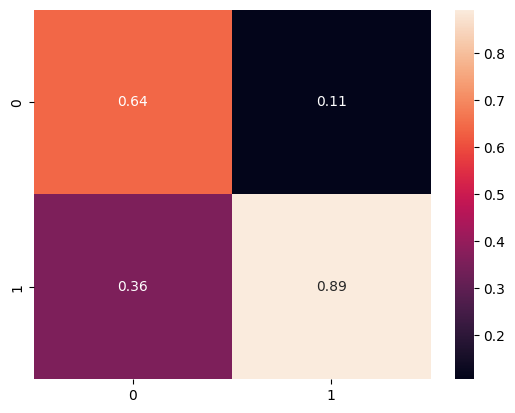

In [78]:
import math

# Menampilkan metriks cross validation dari model
print(classification_report(y_test_pad, y_pred))

# Print MSE dan RMSE untuk melihat nilai error
MSE = mean_squared_error(y_test_pad, y_pred)
RMSE = math.sqrt(MSE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)

# menampilkan confusion matrix dalam bentuk heamap
cf_matrix = confusion_matrix(y_test_pad, y_pred , normalize='pred')
sns.heatmap(cf_matrix, annot=True)

In [79]:
input_shape_1 = get_lstm_input_shape(model1, 'lstm-1')
input_shape_2 = get_lstm_input_shape(model1, 'lstm-2')

model_1_test_1 = np.expand_dims(np.ones(input_shape_1[1:]),axis=0)
model_1_test_2 = np.expand_dims(np.ones(input_shape_2[1:]),axis=0)

model_1_test_1.shape
model_1_test_2.shape

(1, 100, 64)

Time step 1
Input gate activation: [0.19138597 0.44469116 0.20163206 0.22863656 0.33559209 0.33008124
 0.25390934 0.07608469 0.48980105 0.24613341 0.33450108 0.17173218
 0.66056214 0.3059133  0.21080114 0.32738579 0.3781393  0.2382308
 0.21935418 0.48010247 0.28702061 0.26067753 0.52941969 0.19874388
 0.46057703 0.40767167 0.79129361 0.34609841 0.22759137 0.17500573
 0.44994872 0.22387415 0.24488305 0.31570876 0.49584407 0.22631202
 0.22750607 0.26680539 0.30643976 0.21638902 0.17091082 0.27444104
 0.24567221 0.31284672 0.38011873 0.42021212 0.38740839 0.59348591
 0.35842573 0.50551665 0.24309392 0.23302876 0.43588193 0.43009041
 0.41214437 0.28477078 0.16215528 0.38896361 0.44008567 0.31968402
 0.44027444 0.37438213 0.47032985 0.48327417]
Forget gate activation: [0.55581798 0.87170273 0.73763532 0.28604663 0.49230349 0.54285993
 0.75391181 0.65189121 0.46705287 0.59523885 0.51790614 0.38652372
 0.80656958 0.73986173 0.43498383 0.66228916 0.4737928  0.68511833
 0.796117   0.78197189 0.

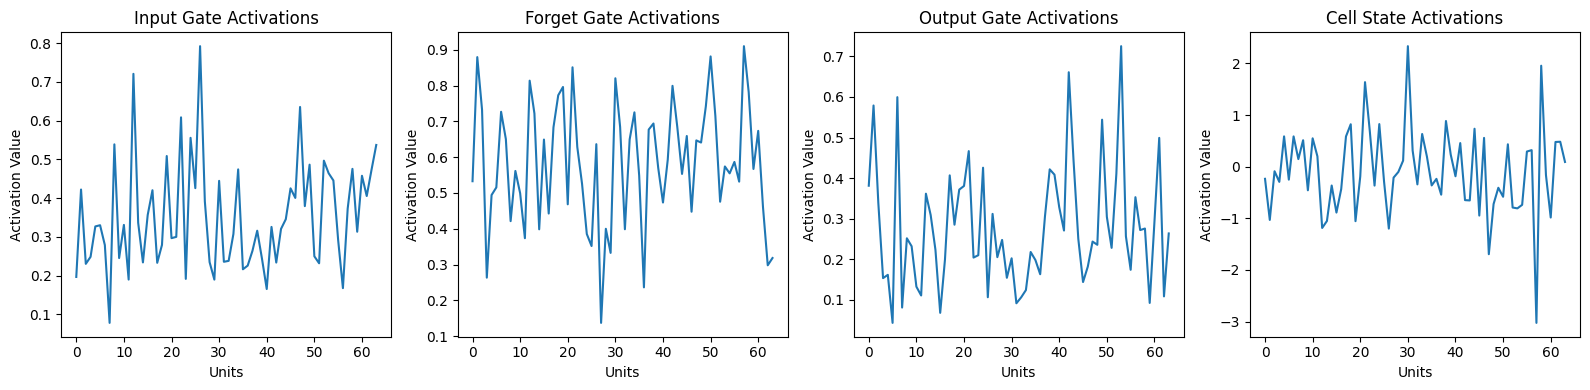

In [80]:
plot_lstm_gate_activations(model1, 'lstm-1', model_1_test_1)

Time step 1
Input gate activation: [0.37533819 0.57203219 0.62001572 0.51216113 0.29489996 0.49971221
 0.65701459 0.49780652 0.45900449 0.57214062 0.35812987 0.5923743
 0.53766897 0.67877808 0.38803832 0.67012539 0.52065235 0.59126174
 0.25284941 0.60740039 0.19691697 0.27955261 0.74071818 0.34982593
 0.5372503  0.41132148 0.43637782 0.37910739 0.18787865 0.52382372
 0.40568365 0.29644355 0.55393772 0.69821917 0.38378093 0.30059977
 0.6973178  0.59933481 0.34821715 0.30654462 0.57678489 0.39477922
 0.3488336  0.44927327 0.18080783 0.39468367 0.48802108 0.52487835
 0.59604757 0.34110231 0.24863441 0.43712554 0.63859737 0.65549893
 0.35156416 0.45096564 0.4786065  0.30282363 0.57017891 0.27765355
 0.27139812 0.44868267 0.56863246 0.4251112 ]
Forget gate activation: [0.82916328 0.36731563 0.57272051 0.67113372 0.86980553 0.6385888
 0.91156453 0.68630185 0.78057126 0.77337081 0.79750249 0.60792778
 0.66303956 0.30180833 0.73271564 0.65470837 0.95454597 0.42454414
 0.58956069 0.72292813 0.7

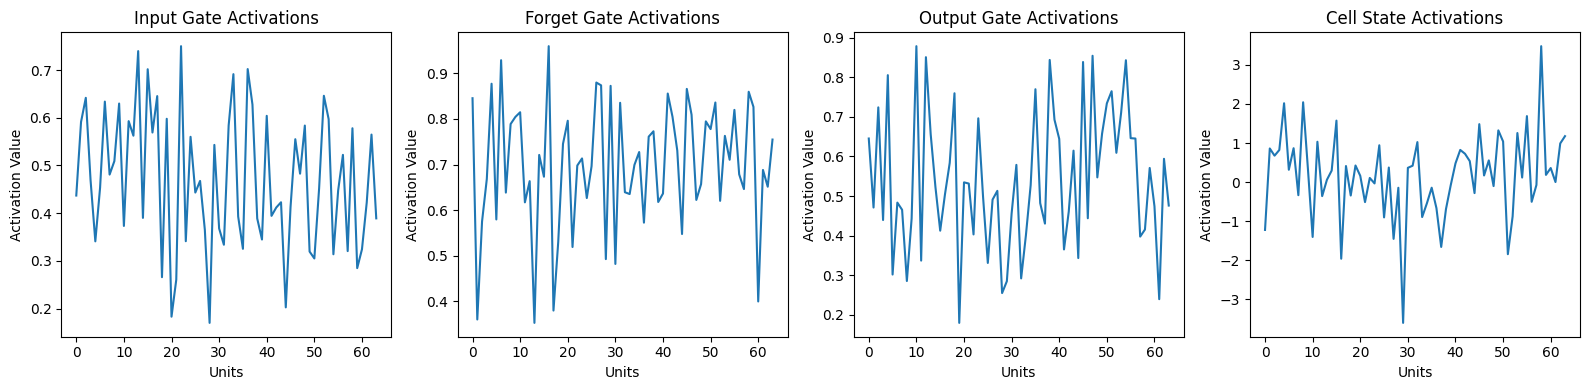

In [81]:
plot_lstm_gate_activations(model1, 'lstm-2', model_1_test_2)

# BUILDING MODELS #2

In [82]:
vocab_size = len(wordvector.wv)
embedding_dim = wordvector.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {word: idx for idx, word in enumerate(wordvector.wv.index_to_key)}
for word, idx in word_index.items():
    embedding_matrix[idx] = wordvector.wv[word]

In [83]:
model2 = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=100,
              trainable=False),
    LSTM(64, return_sequences=True, name='lstm-1'),
    LSTM(64, return_sequences=True, name='lstm-2'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [84]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          33499100  
                                                                 
 lstm-1 (LSTM)               (None, 100, 64)           42240     
                                                                 
 lstm-2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 batch_normalization_4 (Bat  (None, 100, 64)           256       
 chNormalization)                                                
                                                                 
 global_average_pooling1d_4  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 64)               

In [85]:
model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [90]:
print ('Fitting model...')
hist = model2.fit(X_train_pad, y_train_pad, steps_per_epoch=100, batch_size=64, epochs=40, validation_data=(X_val_pad,y_val_pad), verbose=1, class_weight=class_weight)

Fitting model...
Epoch 1/20
50/50 [==============================] - 1s 29ms/step - loss: 0.8265 - accuracy: 0.7359 - val_loss: 0.6223 - val_accuracy: 0.7194
Epoch 2/20
50/50 [==============================] - 1s 26ms/step - loss: 0.8064 - accuracy: 0.7594 - val_loss: 0.6038 - val_accuracy: 0.7361
Epoch 3/20
50/50 [==============================] - 2s 37ms/step - loss: 0.8062 - accuracy: 0.7544 - val_loss: 0.6700 - val_accuracy: 0.6923
Epoch 4/20
50/50 [==============================] - 2s 37ms/step - loss: 0.7932 - accuracy: 0.7513 - val_loss: 0.5576 - val_accuracy: 0.7707
Epoch 5/20
50/50 [==============================] - 1s 26ms/step - loss: 0.7728 - accuracy: 0.7716 - val_loss: 0.5804 - val_accuracy: 0.7503
Epoch 6/20
50/50 [==============================] - 2s 33ms/step - loss: 0.8067 - accuracy: 0.7563 - val_loss: 0.6597 - val_accuracy: 0.6938
Epoch 7/20
50/50 [==============================] - 2s 38ms/step - loss: 0.7670 - accuracy: 0.7538 - val_loss: 0.5992 - val_accuracy: 0.7

In [91]:
model2.evaluate(X_test_pad, y_test_pad)
model2.save("model-2.h5")

313/313 [==============================] - 2s 6ms/step - loss: 0.5318 - accuracy: 0.7647


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [92]:
# melakukan prediksi lagi untuk menguji model
y_pred_pad = model2.predict(X_test_pad).round()

# menampilkan hasil prediksi dalam bentuk tabel
result_np2 = np.concatenate((y_pred_pad.reshape(len(y_pred), 1), (y_test_pad.reshape(len(y_test_pad), 1))), 1)
result2 = pd.DataFrame(result_np2, columns=['Prediction', 'Real Value'])
result2

313/313 [==============================] - 2s 5ms/step


,Prediction,Real Value
0,1.0,1.0
1,1.0,0.0
2,1.0,1.0
3,0.0,0.0
4,1.0,0.0
...,...,...
9995,1.0,1.0
9996,0.0,0.0
9997,1.0,0.0
9998,0.0,1.0


              precision    recall  f1-score   support

           0       0.55      0.77      0.64      2737
           1       0.90      0.76      0.82      7263

    accuracy                           0.76     10000
   macro avg       0.72      0.77      0.73     10000
weighted avg       0.80      0.76      0.77     10000

Mean Squared Error: 0.2353
Root Mean Squared Error: 0.4850773134253962


<Axes: >

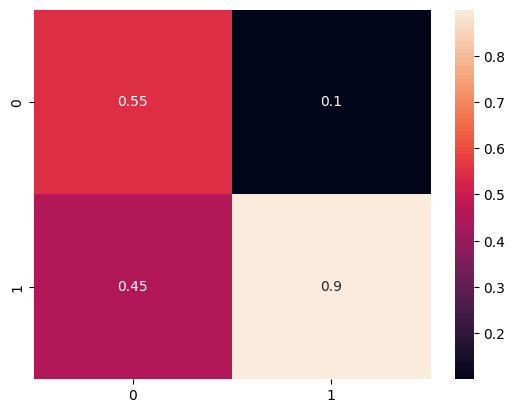

In [93]:
# Menampilkan metriks cross validation dari model
print(classification_report(y_test_pad, y_pred_pad))

# Print MSE dan RMSE untuk melihat nilai error
MSE = mean_squared_error(y_test_pad, y_pred_pad)
RMSE = math.sqrt(MSE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)

# menampilkan confusion matrix dalam bentuk heamap
cf_matrix = confusion_matrix(y_test_pad, y_pred_pad , normalize='pred')
sns.heatmap(cf_matrix, annot=True)

In [94]:
input_shape_1 = get_lstm_input_shape(model2, 'lstm-1')
input_shape_2 = get_lstm_input_shape(model2, 'lstm-2')

model_2_test_1 = np.expand_dims(np.ones(input_shape_1[1:]),axis=0)
model_2_test_2 = np.expand_dims(np.ones(input_shape_2[1:]),axis=0)

print(input_shape_1)
print(input_shape_2)

(None, 100, 100)
(None, 100, 64)


Time step 1
Input gate activation: [0.46325966 0.47551916 0.28041922 0.68593014 0.49991171 0.15419708
 0.51424848 0.69797515 0.66099679 0.45460953 0.62328835 0.67207501
 0.37297823 0.82505201 0.74610438 0.4377312  0.45104677 0.72928824
 0.46748684 0.23411164 0.40388942 0.64773011 0.37416916 0.37119815
 0.25555228 0.26422839 0.52418545 0.22227386 0.34671067 0.3975247
 0.65896966 0.42515277 0.65011216 0.60559184 0.84949173 0.45057413
 0.54584678 0.52766208 0.32084406 0.40669292 0.3194985  0.4035033
 0.58885535 0.34966531 0.26556022 0.47594295 0.59519131 0.50745061
 0.48314696 0.45360399 0.31370075 0.67078591 0.7176048  0.64379593
 0.5886789  0.3348217  0.19223722 0.48367307 0.51163246 0.49082026
 0.32602325 0.35773909 0.61274264 0.70757663]
Forget gate activation: [0.8703331  0.63270876 0.71087752 0.78122554 0.7906592  0.72918494
 0.90036103 0.7208896  0.91302219 0.59334854 0.46486967 0.89828272
 0.57536436 0.71591231 0.721326   0.73055508 0.76659387 0.68912352
 0.86331786 0.93802315 0.5

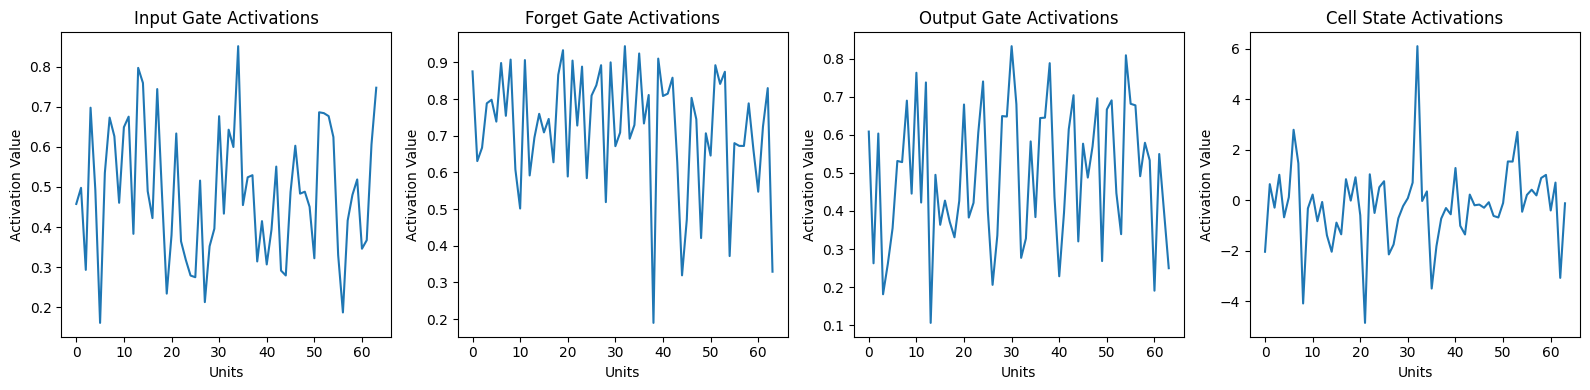

In [95]:
plot_lstm_gate_activations(model2, 'lstm-1', model_2_test_1)

Time step 1
Input gate activation: [0.58557182 0.22803055 0.42758437 0.56399574 0.6310722  0.34546463
 0.50081448 0.63135442 0.67317681 0.55271929 0.43516542 0.32847759
 0.75208463 0.66415504 0.4660758  0.37264089 0.5971321  0.28580953
 0.34490662 0.56581061 0.67138516 0.41038203 0.454871   0.51274781
 0.5176437  0.55094361 0.50337622 0.42648362 0.36763145 0.38686562
 0.52352175 0.62770356 0.74563027 0.46440802 0.35160839 0.5373369
 0.67753045 0.55694684 0.57144419 0.43388763 0.72333906 0.54187785
 0.49893655 0.61462124 0.54786582 0.57762457 0.63614429 0.3841397
 0.62300073 0.66469431 0.25999347 0.49327513 0.40125898 0.41029465
 0.31143481 0.60305321 0.57034717 0.59707665 0.60956264 0.77814829
 0.6394969  0.38896912 0.34723367 0.23322015]
Forget gate activation: [0.67721533 0.79525728 0.75432548 0.52409504 0.59392033 0.65712695
 0.73038465 0.75106135 0.88078179 0.75358378 0.56931143 0.7185954
 0.87537939 0.72151674 0.71078982 0.79310371 0.67237874 0.54623741
 0.68758128 0.82575315 0.56

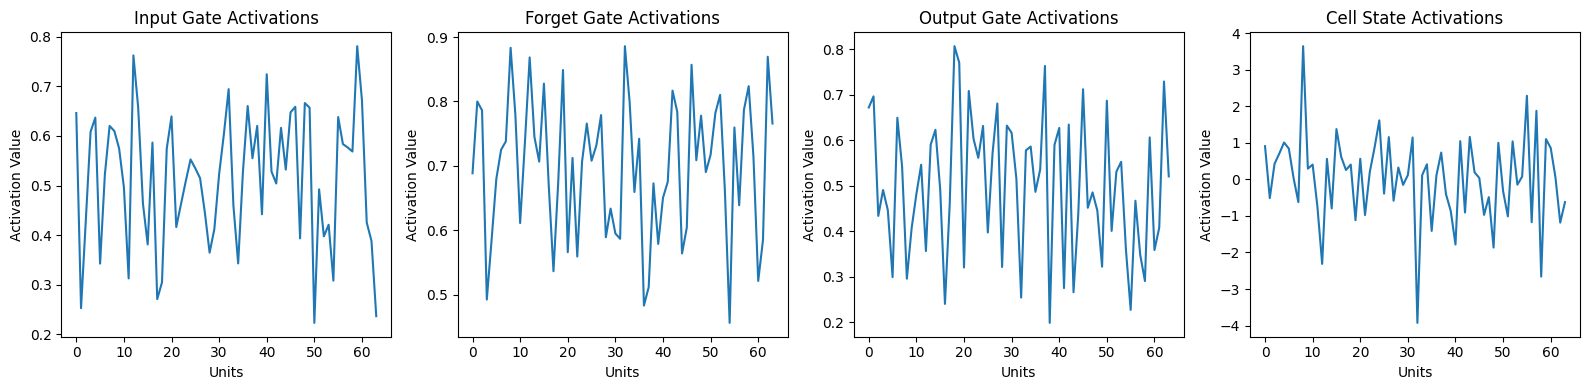

In [96]:
plot_lstm_gate_activations(model2, 'lstm-2', model_2_test_2)

# Testing

In [97]:
def classify_model_1(text):
  text = preprocess_text(text)
  seq = tok.texts_to_sequences(text)
  max_length = 100
  content = pad_sequences(seq, maxlen=max_length)
  pred = model1.predict(content)

  if pred[0] == 0 :
    print('the text is in formal form')
  else:
    print('text in a non formal form')


In [98]:
def classify_model_2(text):
  text = preprocess_text(text)
  seq = tok.texts_to_sequences(text)
  max_length = 100
  content = pad_sequences(seq, maxlen=max_length)
  pred = model2.predict(content)

  if pred[0] == 0 :
    print('the text is in formal form')
  else:
    print('text in a non formal form')

In [99]:
text_2 = "yo bro apa yang lu lakuin disono"
classify_model_1(text_2)
classify_model_2(text_2)

1/1 [==============================] - 0s 32ms/step
text in a non formal form
1/1 [==============================] - 0s 24ms/step
text in a non formal form


In [105]:
simulate = berita_raw[50000:51000]

In [111]:
simulate = clean_up(simulate)

<ipython-input-106-0a673b8bb530>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berita['content'] = berita['content'].str.lower()
<ipython-input-106-0a673b8bb530>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berita['content'] = berita['content'].apply(lambda kalimat: re.sub(r'[^a-zA-Z\s]', '', kalimat))
<ipython-input-106-0a673b8bb530>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [113]:
proceed_simulate = simulate['content'].apply(preprocess_text)

In [117]:
proceed_simulate.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 50000 to 50999
Series name: content
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [114]:
label_simulate = np.array([ 0 if word == 'formal' else 1 for word in simulate['label']])

In [144]:
def simulate_model1(simulate, num):
  seq = tok.texts_to_sequences(simulate)
  max_length = 100
  content = pad_sequences(seq, maxlen=max_length)
  pred = model1.predict(content)
  list_content = list(simulate)

  for i in range(num):
    print(" ".join(list_content[i]))
    if pred[i] < 0.5 :
      print('the text is in formal form\n')
    else:
      print('text in a non formal form\n')

In [146]:
def simulate_model2(simulate, num):
  seq = tok.texts_to_sequences(simulate)
  max_length = 100
  content = pad_sequences(seq, maxlen=max_length)
  pred = model2.predict(content)
  list_content = list(simulate)

  for i in range(num):
    print(" ".join(list_content[i]))
    if pred[i] < 0.5 :
      print('the text is in formal form\n')
    else:
      print('text in a non formal form\n')

In [145]:
simulate_model1(proceed_simulate, 10)

32/32 [==============================] - 0s 7ms/step
hotspur terpeleset markas southampton kalah laga pekan liga inggris stadion st mary rabu januari hasil buruk diperparah cedera diderita penyerang andalan spur harry kane gol tunggal danny ings mengantarkan southampton tim inggris ketiga manchester united chelsea memetik poin penuh tottenham kedatangan jose mourinho var bertanggung kekalahan tottenham lantaran menganulir gol kane pertengahan babak catatan laman resmi liga inggris kemenangan diraih southampton tim besutan ralph hassenhuettl merangsek urutan klasemen koleksi poin tottenham tertahan posisi keenam tim bermain terbuka mengancam gawang tandukan cedric soares melenceng tembakan kane kotak penalti diselamatkan kiper alex mccarthy tuan rumah kubu memetik hasil berimbangnya permainan tim menit jack stephen mengirim umpan lambung disambut tendangan voli ings kiper paulo gazzaniga mati langkah menit menjelang turun minum tottenham peluang emas menyamakan kedudukan sepak pojok chr

In [147]:
simulate_model2(proceed_simulate, 10)

32/32 [==============================] - 0s 7ms/step
hotspur terpeleset markas southampton kalah laga pekan liga inggris stadion st mary rabu januari hasil buruk diperparah cedera diderita penyerang andalan spur harry kane gol tunggal danny ings mengantarkan southampton tim inggris ketiga manchester united chelsea memetik poin penuh tottenham kedatangan jose mourinho var bertanggung kekalahan tottenham lantaran menganulir gol kane pertengahan babak catatan laman resmi liga inggris kemenangan diraih southampton tim besutan ralph hassenhuettl merangsek urutan klasemen koleksi poin tottenham tertahan posisi keenam tim bermain terbuka mengancam gawang tandukan cedric soares melenceng tembakan kane kotak penalti diselamatkan kiper alex mccarthy tuan rumah kubu memetik hasil berimbangnya permainan tim menit jack stephen mengirim umpan lambung disambut tendangan voli ings kiper paulo gazzaniga mati langkah menit menjelang turun minum tottenham peluang emas menyamakan kedudukan sepak pojok chr